In [5]:

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from torch.optim.optimizer import Optimizer
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import random
import torch
import warnings 
warnings.filterwarnings('ignore')
from pytorch_lightning import seed_everything
import os
import gc
from transformers import pipeline
import requests
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForQuestionAnswering
from transformers import Trainer, TrainingArguments
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 
gc.collect()

374

# functions

In [6]:
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

def set_seed(seed = int):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    seed_everything(seed)
    return random_state
random_state = set_seed(42)

#MADGRAD 
exec(requests.get('https://raw.githubusercontent.com/facebookresearch/madgrad/main/madgrad/madgrad.py').text)

Global seed set to 42


# LOAD DATA

In [9]:
from sklearn.model_selection import train_test_split
df = pd.read_csv('../data/preprocess_for_SQUAD_開狀人.csv',index_col=0)
#df['string_X_train'] = df['string_X_train'].apply(lambda x:x.replace('x000D',' '))
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
display(train_df)
display(val_df)

,string_X_train,Y_label,string_Y_1,string_Y_2
123,VINMAR INTERNATIONAL LLC_x000D_16825 NORTHCHAS...,VINMAR INTERNATIONAL LLC,0,24
12224,HYUNDAI CORPORATION_x000D_25 YULGOKRO 2GIL JON...,HYUNDAI CORPORATION,0,19
1952,GOVERDHAN VENTURES PRIVATE LIMITED_x000D_19A S...,GOVERDHAN VENTURES PRIVATE LIMITED,0,34
10600,FIRSTEVER ENTERPRISES LIMITED_x000D_JIPFA BUIL...,FIRSTEVER ENTERPRISES LIMITED,0,29
6843,ARUM ELECYRONICS COLTD_x000D_6475SEONGGOKDONG...,ARUM ELECYRONICS COLTD,0,23
...,...,...,...,...
11964,SODINOR_x000D_456 AVENUE DE LATTRE DE TASSIGNY...,SODINOR,0,7
5191,CHIRIPAL POLYFILMS LIMITED_x000D_CHIRIPAL HOUS...,CHIRIPAL POLYFILMS LIMITED,0,26
5390,AKROS TRADING CO LTD _x000D_BWING 241 SHIBAKOE...,AKROS TRADING CO LTD,0,20
860,ZHEJIANG MINGRI HOLDINGS GROUP CO_x000D_LTD NO...,ZHEJIANG MINGRI HOLDINGS GROUP CO,0,33


,string_X_train,Y_label,string_Y_1,string_Y_2
3693,CURRENT INC_x000D_30 TYLER ST EXTENSION_x000D_...,CURRENT INC,0,11
4902,UNICO GLOBAL INC_x000D_904 PANGYO WOOLIM WCITY...,UNICO GLOBAL INC,0,16
4913,UNICO GLOBAL INC_x000D_904 PANGYO WOOLIM WCITY...,UNICO GLOBAL INC,0,16
3154,UNIEXCEL LIMITED TAIWAN BRANCH_x000D_HONG KONG...,UNIEXCEL LIMITED TAIWAN BRANCH,0,30
4415,SHRIRAM AXIALL PRIVATE LIMITED_x000D_SHRIRAM N...,SHRIRAM AXIALL PRIVATE LIMITED,0,30
...,...,...,...,...
10920,YUEYANG GUANSHENG INVESTMENT_x000D_DEVELOPMENT...,YUEYANG GUANSHENG INVESTMENT,0,28
7903,FUJIAN JINLUN FIBER SHAREHOLDING_x000D_COMPANY...,FUJIAN JINLUN FIBER SHAREHOLDING,0,32
7729,L D INTERNATIONAL_x000D_308 KARKAR DOOMA VILLA...,L D INTERNATIONAL,0,17
1691,FUTURE COMPOSITES TECHNOLOGY LLC_x000D_SAIH SH...,FUTURE COMPOSITES TECHNOLOGY LLC,0,32


# Model and Tokenizer Initialization

In [10]:
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForQuestionAnswering

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
gc.collect()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

752

# Data preprocessing

In [11]:
def preprocessing(df):
    contexts = df['string_X_train'].values.tolist()
    questions = [ 'What is the Applicant name ?' for i in range(len(df))]
    answers = []
    for idx in df.index:
        answers.append({
            'text':df.loc[idx,'Y_label'],
            'answer_start':df.loc[idx,'string_Y_1'],
            'answer_end':df.loc[idx,'string_Y_2'],
            })
    return contexts ,questions ,answers

In [12]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})
    return encodings

In [13]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [14]:
def df2Dataloader(df):
    contexts ,questions ,answers = preprocessing(df)
    encodings = tokenizer(contexts, questions, truncation=True, padding=True)
    encodings = add_token_positions(encodings, answers)
    dataset = SquadDataset(encodings)
    return DataLoader(dataset,batch_size=8)

In [15]:
train_loader = df2Dataloader(train_df)
val_loader = df2Dataloader(val_df)

# train model

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.train()
optimizer = MADGRAD(model.parameters() ,lr = 5e-5)

In [17]:

def step(model,batch,optimizer,device,mode='train'):
    model = model.to(device)
    # change mode
    if mode == 'train':
        model.train()
    if mode == 'val':
        model.eval()
    # forward pass
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    # update model if mode == train
    if mode == 'train': 
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return loss.item()

In [18]:
def train_loop(model,train_loader,val_loader,optimizer,max_epochs=5):
    history = {'train_loss':[],'val_loss':[]}
    best_loss = np.inf
    best_model = None
    for epoch in tqdm(range(max_epochs)):        
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0
        for i,batch in enumerate(tqdm(train_loader)):
            epoch_train_loss += step(model,batch,optimizer,device,mode='train')
        for j,batch in enumerate(tqdm(val_loader)):
            epoch_val_loss += step(model,batch,optimizer,device,mode='val')
        history['train_loss'].append(epoch_train_loss/i)
        history['val_loss'].append(epoch_val_loss/j)
        print(f'epoch:{epoch} train_loss:{epoch_train_loss/i} val_loss:{epoch_val_loss/j}')
        if history['val_loss'][-1] <= best_loss: 
            best_model = deepcopy(model.eval())
            best_loss = history['val_loss'][-1]
            print(f'save best_model now_val_best_loss is:{best_loss}')
    return best_model.eval() ,history

In [19]:
best_model ,history = train_loop(model,train_loader,val_loader,optimizer,max_epochs=3)


epoch:0 train_loss:0.050796260801199235 val_loss:0.004509508229408682
save best_model now_val_best_loss is:0.004509508229408682



epoch:1 train_loss:0.002433770482584967 val_loss:0.006214910042170432



epoch:2 train_loss:0.017164842573296223 val_loss:3.378217360029595e-05
save best_model now_val_best_loss is:3.378217360029595e-05



# save model

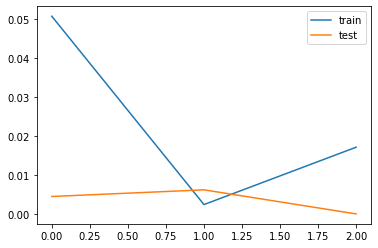

In [20]:

import matplotlib.pyplot as plt
plt.plot(history['train_loss'],label='train')
plt.plot(history['val_loss'],label='test')
plt.legend()
plt.show()

In [21]:
model_path = '../models/Product_Data_SQuAD_model_開狀人.pt'
torch.save(best_model.state_dict(),model_path)

# load trained model

In [22]:
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
model.load_state_dict(torch.load(model_path))
model.eval()
nlp = pipeline('question-answering', model=model.to('cpu'), tokenizer=tokenizer)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

# test

In [23]:
def test_model(nlp,df):
    table = pd.DataFrame()
    for i in tqdm(df.index):
        sample = df.loc[[i]]
        string_X_train = sample['string_X_train'].values[0]
        Y_label = sample['Y_label'].values[0]  
        QA_input = {
            'question': 'What is the Applicant name ?',
            'context': string_X_train
        }
        res = nlp(QA_input)
        predict = QA_input['context'][0:res['end']]
        row = pd.DataFrame({'Y_label':Y_label,'predict':predict},index=[i])
        if Y_label == predict:
            row['是否全對'] = 'Yes'
        else:
            row['是否全對'] = 'No'
        table = table.append(row)
    return table

In [24]:
table = test_model(nlp,val_df)
display(table)

,Y_label,predict,是否全對
3693,CURRENT INC,CURRENT INC,Yes
4902,UNICO GLOBAL INC,UNICO GLOBAL INC,Yes
4913,UNICO GLOBAL INC,UNICO GLOBAL INC,Yes
3154,UNIEXCEL LIMITED TAIWAN BRANCH,UNIEXCEL LIMITED TAIWAN BRANCH,Yes
4415,SHRIRAM AXIALL PRIVATE LIMITED,SHRIRAM AXIALL PRIVATE LIMITED,Yes
...,...,...,...
10920,YUEYANG GUANSHENG INVESTMENT,YUEYANG GUANSHENG INVESTMENT,Yes
7903,FUJIAN JINLUN FIBER SHAREHOLDING,FUJIAN JINLUN FIBER SHAREHOLDING,Yes
7729,L D INTERNATIONAL,L D INTERNATIONAL,Yes
1691,FUTURE COMPOSITES TECHNOLOGY LLC,FUTURE COMPOSITES TECHNOLOGY LLC,Yes


# claculate acc and jaccard

In [25]:
def get_acc(df,t=1):
    correct = []
    correct_label = []
    for i in df.index:
        jac = get_jaccard_sim(df.loc[i,'Y_label'],df.loc[i,'predict'])
        if jac >= t:
            correct.append('yes')
        else:
            correct.append('no')
    a = pd.Series(correct)
    return a.value_counts()['yes']/len(a)

In [26]:

print('jaccard_avg_score:',np.mean([ get_jaccard_sim(table['Y_label'].loc[i],table['predict'].loc[i]) for i in table.index]))
print('acc:',get_acc(table,1))
print('放水acc:',get_acc(table,0.75))
print('放水acc:',get_acc(table,0.5))
print('放水acc:',get_acc(table,0.25))

jaccard_avg_score: 0.9697546373031026
acc: 0.9466882067851373
放水acc: 0.9584006462035541
放水acc: 0.970113085621971
放水acc: 0.9830371567043619
